In [5]:
import pathlib
import sys
import os

# Hacky way to get to root package
if "notebooks" in os.getcwd():
    os.chdir("..")

In [6]:
%load_ext autoreload
%autoreload 2
    
import sys
from data_container import load_scouted_data
import pandas as pd
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
scouted_data = load_scouted_data()
scouted_data


,Scouter Initials,Match Number,Team Number,No Show,Auto Fuel,Auto Climbing Status,Auto Human Player Score,Teleop Fuel,Teleop Human Player Score,Endgame Climbing Level
0,abc,1,1678,False,14,True,12,49,6,L1
1,abc,1,3504,True,15,True,10,20,3,NaN
2,abc,1,8393,False,13,False,6,152,8,L2
3,abc,1,118,True,9,True,2,175,5,L1
4,abc,1,254,True,4,False,3,12,18,L3
5,abc,1,67,False,12,True,16,98,13,L1
6,abc,2,8393,False,7,False,10,190,8,L1
7,abc,2,67,True,15,True,7,144,30,L2
8,abc,2,118,True,3,True,14,64,26,NaN
9,abc,2,1678,False,2,False,1,198,0,L2


NameError: name 'load_pit_data' is not defined

             Match Number   No Show  Auto Fuel  Auto Climbing Status  \
Team Number                                                            
67               5.555556  0.555556   9.444444              0.444444   
118              6.142857  0.571429   8.428571              0.428571   
254              5.750000  0.375000   8.000000              0.500000   
1678             5.500000  0.400000   5.300000              0.400000   
2056             4.250000  0.500000  12.000000              0.750000   
3504             5.285714  0.285714  17.571429              0.857143   
4467             5.400000  0.200000   9.800000              0.800000   
8393             5.500000  0.300000   8.100000              0.200000   

             Auto Human Player Score  Teleop Fuel  Teleop Human Player Score  
Team Number                                                                   
67                          9.333333   135.666667                  22.666667  
118                        10.857143   125

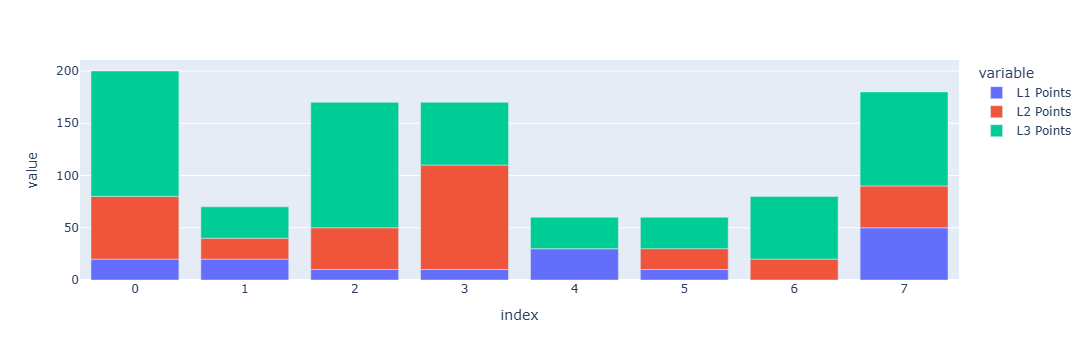

In [17]:
avg_team = scouted_data.groupby("Team Number").mean(numeric_only = True)
print(avg_team)
endgame_df = scouted_data.groupby("Team Number")["Endgame Climbing Level"].value_counts().unstack(fill_value=0).reset_index()
endgame_df["L1 Points"] = endgame_df["L1"] * 10
endgame_df["L2 Points"] = endgame_df["L2"] * 20
endgame_df["L3 Points"] = endgame_df["L3"] * 30
print(endgame_df)
fig = px.bar(endgame_df, x = endgame_df.index, y = ["L1 Points", "L2 Points", "L3 Points"])
fig.show()